In [2]:
import pandas as pd

# Load the dataset
df = pd.read_excel(r"df_dataset_mfcc_merged.xlsx")

# Display the first few rows
print(df.head())

# Check column names and data types
print(df.info())

   Unnamed: 0                                               file  \
0           0  2019-10-22-08-40_Fraunhofer-IDMT_30Kmh_1007744...   
1           1  2019-10-22-08-40_Fraunhofer-IDMT_30Kmh_1007744...   
2           2  2019-10-22-08-40_Fraunhofer-IDMT_30Kmh_1017344...   
3           3  2019-10-22-08-40_Fraunhofer-IDMT_30Kmh_1017344...   
4           4  2019-10-22-08-40_Fraunhofer-IDMT_30Kmh_1026944...   

   is_background         date_time         location speed_kmh  sample_pos  \
0           True  2019-10-22-08-40  Fraunhofer-IDMT        30    10077440   
1           True  2019-10-22-08-40  Fraunhofer-IDMT        30    10077440   
2           True  2019-10-22-08-40  Fraunhofer-IDMT        30    10173440   
3           True  2019-10-22-08-40  Fraunhofer-IDMT        30    10173440   
4           True  2019-10-22-08-40  Fraunhofer-IDMT        30    10269440   

  daytime weather vehicle  ...    mfcc_5    mfcc_6    mfcc_7    mfcc_8  \
0     NaN     NaN     NaN  ...  2.379229  2.360137  0.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

# Load the dataset
df = pd.read_excel(r"df_dataset_mfcc_merged.xlsx")

# Filter rows where 'vehicle' is valid
df = df[df['vehicle'].notna()]

# Extract features and target
features = [col for col in df.columns if col.startswith('mfcc_')]
X = df[features]
y = df['vehicle']

# Encode the target into numeric labels for multiclass classification
y_encoded = y.astype('category').cat.codes
label_mapping = dict(enumerate(y.astype('category').cat.categories))

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Define the pipeline
pipeline = Pipeline([
    ('xgb', XGBClassifier(eval_metric='mlogloss'))  # Multiclass support
])

# Define a smaller parameter grid for GridSearchCV
param_grid = {
    'xgb__n_estimators': [100],             # Number of boosting rounds
    'xgb__learning_rate': [0.1, 0.3],           # Learning rate (eta)
    'xgb__max_depth': [3],                   # Maximum depth of trees
    'xgb__gamma': [0, 1],                       # Minimum loss reduction to split
    'xgb__reg_alpha': [0, 0.1],                 # L1 regularization term
    'xgb__reg_lambda': [1, 1.5]                 # L2 regularization term
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,                 # 3-fold cross-validation
    scoring='f1_macro',   # Optimize for macro F1 score for multiclass
    verbose=1,
    n_jobs=-1             # Use all available CPUs
)

# Perform Grid Search
grid_search.fit(X_train, y_train)

# Get the best parameters and model
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Evaluate the model on the test set
y_pred = best_model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_mapping.values()))

# Save the label mapping
print("Label Mapping (Numeric to Vehicle):")
print(label_mapping)

Best Parameters: {'xgb__gamma': 0, 'xgb__learning_rate': 0.3, 'xgb__max_depth': 3, 'xgb__n_estimators': 100, 'xgb__reg_alpha': 0.1, 'xgb__reg_lambda': 1}
Classification Report:
              precision    recall  f1-score   support

           B       0.54      0.33      0.41        21
           C       0.89      0.98      0.94      1561
           M       0.93      0.90      0.91        86
           T       0.59      0.17      0.27       205

    accuracy                           0.88      1873
   macro avg       0.74      0.60      0.63      1873
weighted avg       0.86      0.88      0.86      1873

Label Mapping (Numeric to Vehicle):
{0: 'B', 1: 'C', 2: 'M', 3: 'T'}


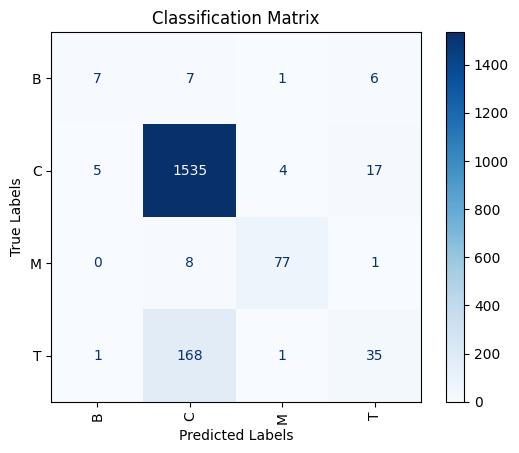

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create the confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_mapping.values())

# Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Classification Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


### XGBoost with SMOTE to improve performance on minority classes

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from xgboost import XGBClassifier

# Load the dataset
df = pd.read_excel(r"df_dataset_mfcc_merged.xlsx")

# Filter rows where 'vehicle' is valid
df = df[df['vehicle'].notna()]

# Extract features and target
features = [col for col in df.columns if col.startswith('mfcc_')]
X = df[features]
y = df['vehicle']

# Encode the target into numeric labels for multiclass classification
y_encoded = y.astype('category').cat.codes
label_mapping = dict(enumerate(y.astype('category').cat.categories))

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Define the pipeline with SMOTE and XGBClassifier
pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),  # SMOTE for balancing the data
    ('xgb', XGBClassifier(eval_metric='mlogloss'))
])

# Define parameter grid
param_grid = {
    'xgb__n_estimators': [100],               # Number of boosting rounds
    'xgb__learning_rate': [0.1, 0.3],         # Learning rate (eta)
    'xgb__max_depth': [3],                    # Maximum depth of trees
    'xgb__gamma': [0, 1],                     # Minimum loss reduction to split
    'xgb__reg_alpha': [0, 0.1],               # L1 regularization term
    'xgb__reg_lambda': [1, 1.5]               # L2 regularization term
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,                     # 5-fold cross-validation
    scoring='f1_macro',       # Optimize for macro F1 score for multiclass
    verbose=1,
    n_jobs=-1                 # Use all available CPUs
)

# Perform Grid Search
grid_search.fit(X_train, y_train)

# Get the best parameters and model
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Evaluate the model on the test set
y_pred = best_model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_mapping.values()))

# Save the label mapping
print("Label Mapping (Numeric to Vehicle):")
print(label_mapping)


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters: {'xgb__gamma': 1, 'xgb__learning_rate': 0.3, 'xgb__max_depth': 3, 'xgb__n_estimators': 100, 'xgb__reg_alpha': 0.1, 'xgb__reg_lambda': 1}
Classification Report:
              precision    recall  f1-score   support

           B       0.38      0.71      0.49        21
           C       0.94      0.79      0.86      1561
           M       0.87      0.94      0.91        86
           T       0.29      0.61      0.39       205

    accuracy                           0.78      1873
   macro avg       0.62      0.76      0.66      1873
weighted avg       0.86      0.78      0.81      1873

Label Mapping (Numeric to Vehicle):
{0: 'B', 1: 'C', 2: 'M', 3: 'T'}


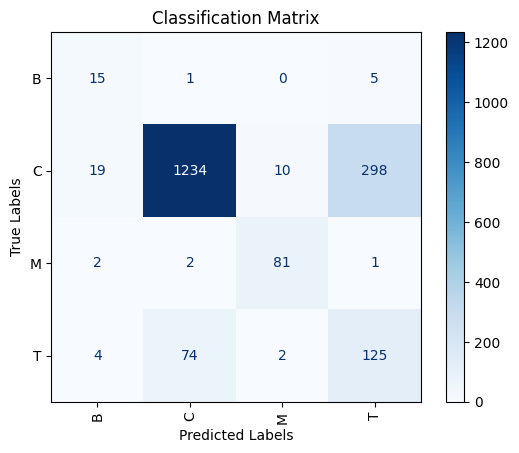

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create the confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_mapping.values())

# Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Classification Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()
